In [1]:
import os
import sys
# Get the current working directory and add the parent directory to the Python path
current_working_directory = os.getcwd()
sys.path.append(os.path.join(current_working_directory, "../.."))
sys.path.insert(0, os.path.join(current_working_directory, "../.."))
print(os.path.join(current_working_directory, "../.."))

/Users/L024258/lilly_work/github-copilot/exploration/langgraph/deep-researcher/../..


In [2]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.messages import BaseMessage, ToolMessage, AnyMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import operator
import json

from IPython.display import Image, display

## Defining the model

In [4]:
from models.llm import LLM

model = LLM('gpt-4o')
llm = model.load_model()

## Defining the Tools

In [5]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults

arxiv_search = ArxivQueryRun()
tavily_tool = TavilySearchResults(max_results=5)

tools = [arxiv_search, tavily_tool]

In [6]:
from langchain_core.tools import tool

@tool
def get_todays_date() -> str:
    """This tool is used to get today's date in the format 'YYYY-MM-DD'."""
    from datetime import date
    today = date.today()
    return today.strftime("%Y-%m-%d")

tools.append(get_todays_date)

## Defining the Workflow

### Agent State

In [7]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AnyMessage, None]
    retrieved_results: Union[AnyMessage, None]
    intermediate_step: Annotated[list[AnyMessage], operator.add]
    draft: Union[AnyMessage, None]
    revision_steps: Annotated[list[AnyMessage], operator.add]
    doc_schema: List[BaseMessage]

class ReflectState(TypedDict):
    input: str
    draft: Union[AnyMessage, None]
    revision_steps: Annotated[list[AnyMessage], operator.add]
    doc_schema: List[BaseMessage]

class FinalState(TypedDict):
    input: str
    final_draft: Union[AnyMessage, None]
    doc_schema: List[BaseMessage]

### Graph

In [8]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

### Nodes

#### Common Tool Node

In [9]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("----tool calling----")
        message = inputs["agent_outcome"][-1]

        outputs = []
        for tool_call in message.tool_calls:
            print(f"---- Calling {tool_call['name']} with args: {tool_call['args']} ----")
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {
                "agent_outcome": outputs,
                "intermediate_step": outputs
            }

#### Researcher

In [10]:
class ResearchAgent:
    def research_agent(self,
                       data:AgentState):
        print("----research node----")
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "You are a helpful AI research assistant chatbot,"
                    "For recent or latest search queries, first identify the current date using the tool 'get_todays_date'."
                    " Use the appropriate search tools and chat history to progress towards finding the relevant results."
                    " Once you have the relevant search results, return the response in json."
                    "\nYou have access to the following search tools: {tool_names}."
                ),
                (
                    "human",
                    "\nUser Query: {input}"
                ),
                
                MessagesPlaceholder(variable_name="intermediate_step"),
            ]
        )
        prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
        agent = prompt | llm.bind_tools(tools)
        result = agent.invoke(data)
        return {'agent_outcome': [result],
                'retrieved_results': [result],
                'intermediate_step': [result]}
    
    def route_tools(self,
    state: AgentState,
    ):
        """
        Use in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the end.
        """
        print("----router----")
        if isinstance(state, list):
            ai_message = state[-1]
        elif agent_outcome := state.get("agent_outcome", []):
            ai_message = agent_outcome[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")

        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"
        return "END"

In [11]:
research = ResearchAgent()
researcher = research.research_agent
workflow.add_node("research", researcher)

In [12]:
tool_node = BasicToolNode(tools=tools)
workflow.add_node("tools", tool_node)

#### Planner

In [13]:
class PlanAgent:
    def plan_agent(self,
            data:AgentState):
        print("----plan node----")

        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """You are an expert planner tasked with writing a high level outline of an article for the provided user query.
                        Make sure the outline is well structured and succint yet includes all the necessary sections.
                        Plan the outline for a document. If schema is provided, use it to create the outline otherwise do it on your own.
                        Give an outline of the literature review along with any relevant notes or instructions for each of the sections. \ 
                        """
                ),
                (
                    "human",
                    "\nUser Query: {input}"
                ),
                
                MessagesPlaceholder(variable_name="intermediate_step"),
            ]
        )
        agent = prompt | llm
        result = agent.invoke(data)
        return {'agent_outcome': [result],
                'doc_schema': [result],
                'intermediate_step': [result.content]}

In [14]:
plan = PlanAgent()
planner = plan.plan_agent
workflow.add_node("plan", planner)

#### Writer

In [ ]:
class WriteAgent:
    def write_agent(self,
                       data:AgentState):
        print("----write node----")
        
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "You are a skilled writer at a research agency, capable of crafting high-quality articles. "
                    "Your task is to generate a well-structured draft based on the provided document outline and retrieved/input documents. "
                    "\nEnsure accuracy and coherence while strictly adhering to the given information - Do not add any other extra information on your own."
                    "\nInclude necessary references with proper citations to maintain credibility and scholarly integrity.."
                ),
                MessagesPlaceholder(variable_name="retrieved_results"),
                MessagesPlaceholder(variable_name="revision_steps"),
            ]
        )

        agent = prompt | llm
        result = agent.invoke(data)
        return {'agent_outcome': [result],
                'draft': [result],
                'revision_steps': [result],
                'intermediate_step': [result]}
    
    def should_continue(self,
                        state: AgentState):
        if len(state["revision_steps"]) > 4:
            # End after 3 iterations
            return "END"
        return "reflect"
    

In [16]:
write = WriteAgent()
write_agent = write.write_agent
workflow.add_node("write", write_agent)

#### Reviewer (Reflection)

In [17]:
class ReviewAgent:
    def reflect(self,
                data:AgentState):
        print("----reflect node----")

        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "You are a senior editor at research agency, grading an article submission for the provided user query."
                    "  Generate critique and recommendations for the user's submission."
                    " Provide detailed recommendations, including requests for length, depth, style, etc."
                    "\n Ensure that content in the draft is appropriately cited with references.",
                ),
                (
                    "human",
                    "\nUser Query: {input}"
                ),
                MessagesPlaceholder(variable_name="draft"),
            ]
        )

        agent = prompt | llm
        result = agent.invoke(data)



        return {'agent_outcome': [result],
                'revision_steps': [result]}
    

In [18]:
reflect = ReviewAgent()
reflect_agent = reflect.reflect
workflow.add_node("reflect", reflect_agent)

#### Editor

In [19]:
class EditAgent:
    def edit_agent(self,
            data:AgentState):
        print("---- edit node ----")
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """You are an experienced editor. \
                        Combine drafts of multiple sections into a single, coherent final document, ensuring a consistent flow, tone, and structure throughout.
                        Follow the the following doc_schema to generate the final draft.
                        """
                ),
                
                MessagesPlaceholder(variable_name="agent_outcome"),
                MessagesPlaceholder(variable_name="doc_schema"),
            ]
        )
        agent = prompt | llm
        result = agent.invoke(data)
        return {'agent_outcome': [result],
                }

In [20]:
edit = EditAgent()
edit_agent = edit.edit_agent
workflow.add_node("edit", edit_agent)

### Edges

In [21]:
workflow.add_conditional_edges(
    "research",
    research.route_tools,
    {"tools": "tools", "END": "plan"}
)

In [22]:
workflow.add_edge("tools", "research")

In [23]:
workflow.add_edge("plan", "write")

In [24]:
workflow.add_conditional_edges("write", write.should_continue, {"reflect": "reflect", "END": "edit"})
workflow.add_edge("reflect", "write")
workflow.add_edge("edit", END)

### Initialising the memory

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

### Compiling the graph

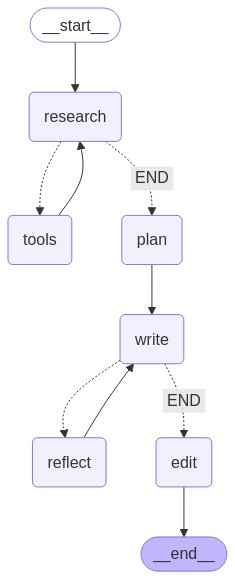

In [26]:
workflow.set_entry_point("research")
app = workflow.compile(checkpointer=memory)
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Testing

In [30]:
inputs = {
    "input": "Summarise todays stocks market news for India?",
}

config = {
    "configurable": {
        "thread_id": "123",
    }
}

inputs["intermediate_step"] = [HumanMessage(inputs["input"])]

state = AgentState(**inputs)
events = app.stream(input=state, config=config, stream_mode="values")
for event in events:
    try:
        event["agent_outcome"][-1].pretty_print()
    except Exception as e:
        HumanMessage(inputs["input"]).pretty_print()

================================ Human Message =================================

Summarise todays stocks market news for India?
----research node----
----router----
================================== Ai Message ==================================
Tool Calls:
  get_todays_date (call_OeeKlF4xoMtuk3R2QiYBA7kR)
 Call ID: call_OeeKlF4xoMtuk3R2QiYBA7kR
  Args:
----tool calling----
---- Calling get_todays_date with args: {} ----
================================= Tool Message =================================
Name: get_todays_date

"2025-03-17"
----research node----
----router----
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Vn4xOQZhBHzOBFCg8MTmitDL)
 Call ID: call_Vn4xOQZhBHzOBFCg8MTmitDL
  Args:
    query: India stock market news March 17 2025
----tool calling----
---- Calling tavily_search_results_json with args: {'query': 'India stock market news March 17 2025'} ----
================================= Tool Me

In [31]:
from IPython.display import display, Markdown
    
final_response = app.get_state(config=config).values['agent_outcome'][-1].content
display(Markdown(final_response))

## Stock Market Valuations in India

India's stock market valuations have undergone a significant correction recently. Previously, the market was considered expensive, with valuations at 24-25 times earnings. However, these valuations have now adjusted to a more reasonable level of 18-19 times earnings. This correction is seen as a positive development, making the market more attractive to investors who were previously deterred by high valuations. The adjustment in valuations reflects a more balanced and sustainable market environment, potentially leading to increased investor confidence and participation ([Livemint](https://www.livemint.com/market/stock-market-news/latest-stock-market-news-on-march-17-2025-live-updates-11742169605614.html)).

## Market Trends and Predictions

The Sensex and Nifty, two of India's major stock indices, are expected to remain range-bound amid ongoing global trade concerns. This prediction suggests that the market may not experience significant upward or downward movements in the near term. The range-bound nature of the market indicates a period of consolidation, where investors are likely to adopt a cautious approach due to uncertainties in global trade dynamics. This scenario underscores the importance of monitoring international trade developments and their potential impact on the Indian stock market ([The Hindu BusinessLine](https://www.thehindubusinessline.com/markets/share-market-nifty-sensex-live-updates-17-march-2025/article69336488.ece)).

## Trade Setup and Stock Recommendations

For investors looking to navigate the current market conditions, specific trade setups and stock recommendations are crucial. Livemint provides insights into the trade setup for the Nifty 50 index and global markets, offering recommendations on seven stocks to buy or sell. These recommendations are based on thorough analysis and are designed to help investors make informed decisions in a volatile market environment. The guidance includes strategic advice on stock selection, taking into account market trends, valuation adjustments, and global economic factors ([Livemint](https://www.livemint.com/market/stock-market-news/stock-market-today-trade-setup-for-nifty-50-to-global-markets-7-stocks-to-buy-or-sell-on-monday-march-17-2025-11742138910370.html)).

## Currency Performance

The performance of the Indian rupee is another critical aspect of the financial market. Recently, the rupee closed at 86.9975 against the US dollar, marking a 0.1% decline for the week. This slight depreciation reflects the broader economic conditions and market sentiment. Additionally, India's financial markets were closed on Friday due to a local holiday, which may have contributed to the currency's performance. The rupee's movement is influenced by various factors, including domestic economic policies, global trade dynamics, and investor sentiment. Monitoring these factors is essential for understanding the currency's trajectory and its impact on the broader financial market ([Reuters](https://www.reuters.com/markets/asia/india-rupee-bonds-take-cues-fed-policy-decision-commentary-2025-03-17/)).

## Introduction

The Indian stock market has been a focal point for investors, analysts, and policymakers, especially in light of recent developments. This article delves into the current state of the market, examining key aspects such as stock valuations, market trends, trade setups, and currency performance. By providing a comprehensive overview, we aim to offer valuable insights into the factors shaping the Indian financial landscape.

## Conclusion

In conclusion, the Indian stock market is undergoing significant changes, with valuations becoming more reasonable and market trends indicating a period of consolidation. Investors are advised to stay informed about trade setups and stock recommendations to navigate the current environment effectively. Additionally, the performance of the Indian rupee remains a critical factor to watch, as it reflects broader economic conditions. By understanding these elements, investors can make more informed decisions and better manage their portfolios in a dynamic market.